In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_cov_ratio(x,y):
    y_var = np.var(y[0,0,0],ddof=1)
    cov = np.cov(x[0,0,0], y[0,0,0])[0][1]
    cov_ratio = (cov/y_var)
    return cov_ratio.reshape(1,1,1)

### Load datasets

In [3]:
# Main disagnostic output
ds_main = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_output/')
coords_main = ds_main.coords.to_dataset().reset_coords()
ds_main = ds_main.reset_coords(drop=True)

In [4]:
# Budget terms
ds_budg = xr.open_zarr('/rigel/ocp/users/jt2796/eccov4r3_budgets')
#ds_budg.time.values = ds_main.time.values
coords_budg = ds_budg.coords.to_dataset().reset_coords()
ds_budg = ds_budg.reset_coords(drop=True)

In [5]:
# Open dataset from file
ds = xr.open_zarr('/rigel/ocp/users/jt2796/anom/aveZ/0300m/')
d = 300

### Plot timeseries (tendencies)

In [16]:
f = 6
j = 9
i = 71

In [17]:
lon = coords_main.XC[f,j,i].values
lat = coords_main.YC[f,j,i].values
print(r'Longitude: %.2f,' % lon,'Latitude: %.2f' % lat)

Longitude: 133.69, Latitude: 73.24


In [18]:
results = dask.compute(ds.tnd[:,f,j,i],
                       ds.hadv_Uanom_Tclim[:,f,j,i],
                       ds.vadv_Uanom_Tclim[:,f,j,i],
                       ds.hadv_Uclim_Tanom[:,f,j,i], 
                       ds.vadv_Uclim_Tanom[:,f,j,i],
                       ds.hdif[:,f,j,i]+ds.vdif[:,f,j,i],
                       ds.frc[:,f,j,i],
                       ds.hadv_Uanom_Tanom[:,f,j,i]+ds.vadv_Uanom_Tanom[:,f,j,i],
                       ds.res[:,f,j,i])

In [19]:
total = results[1] + results[2] + results[3] + results[4] + results[5] + results[6] + results[7] + results[8]
adv = results[1] + results[2] + results[3] + results[4] + results[7]

In [20]:
df = pd.DataFrame({'tnd':results[0],
                   'hadv_Uanom_Tclim':results[1],'vadv_Uanom_Tclim':results[2],
                   'hadv_Uclim_Tanom':results[3],'vadv_Uclim_Tanom':results[4],
                   'dif':results[5],'frc':results[6],
                   'adv_Uanom_Tanom':results[7],'res':results[8],
                   'total':total,'adv':adv})

In [21]:
corr = pd.Series({term: df['tnd'].cov(df[term]) for term in df if term != 'tnd'})/np.var(df.tnd,ddof=1)

In [22]:
corr

hadv_Uanom_Tclim    2.232055e-02
vadv_Uanom_Tclim    1.010400e-10
hadv_Uclim_Tanom    3.696850e-02
vadv_Uclim_Tanom    1.352809e-10
dif                -4.904426e-02
frc                 7.190482e-01
adv_Uanom_Tanom     1.534048e-01
res                 8.331134e-03
total               8.910289e-01
adv                 2.126938e-01
dtype: float64

In [23]:
corr[:8].sum()

0.8910289365897754

In [24]:
varstrngs = ['Tendency',
             r'$\nabla_h(\mathbf{u}^{\prime}\overline{\theta}^m)$',
             r'$\frac{\partial}{\partial z}(\mathbf{u}^{\prime}\overline{\theta}^m)$',
             r'$\nabla_h(\overline{\mathbf{u}}^m\theta^{\prime})$',
             r'$\frac{\partial}{\partial z}(\overline{\mathbf{u}}^m\theta^{\prime})$',
             r'$\nabla{\mathbf{F_{diff}}^{\prime}}$',
             r'$F_{forc}^{\prime}$',
             r'$\nabla({\mathbf{u}}^{\prime}\,\theta^{\prime}-\overline{\mathbf{u}^{\prime}\,\theta^{\prime}}^m)$',
             'Residual',
             'Total','Advection','Diffusion','Forcing']

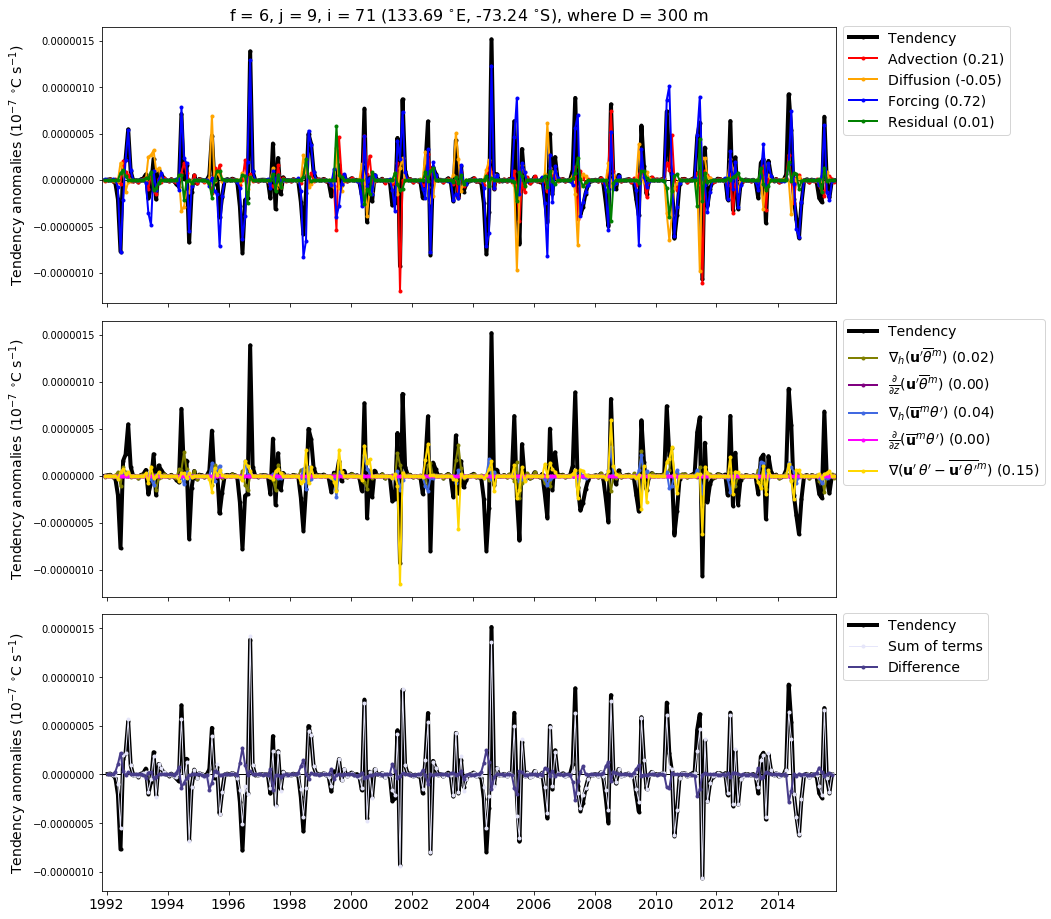

In [25]:
fig, axes = plt.subplots(2, 1,figsize=(17,15))
fig.tight_layout()

plt.subplot(3, 1, 1)
#plt.title(r'f = %s, j = %s, i = %s (%.2f $^{\circ}$W, %.2f $^{\circ}$N), where D = %s m' % (f,j,i,-lon,lat,d), 
#          fontsize=16)
plt.title(r'f = %s, j = %s, i = %s (%.2f $^{\circ}$E, %.2f $^{\circ}$S), where D = %s m' % (f,j,i,lon,-lat,d), 
          fontsize=16)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(adv.time, adv, lw=2, color='red', marker='.',label=varstrngs[10] + ' (%.2f)' % corr[9])
plt.plot(results[5].time, results[5], lw=2, color='orange', marker='.',label=varstrngs[11] + ' (%.2f)' % corr[4])
plt.plot(results[6].time, results[6], lw=2, color='blue', marker='.',label=varstrngs[12] + ' (%.2f)' % corr[5])
plt.plot(results[8].time, results[8], lw=2, color='green', marker='.',label=varstrngs[8] + ' (%.2f)' % corr[7])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
#plt.ylim([-1.9e-7,1.3e-7])
#plt.yticks(np.arange(-1.5e-7,1.5e-7,0.5e-7),fontsize=14)
#plt.setp(plt.gca(), 'yticklabels',np.arange(-1.5,1.5,0.5))
plt.ylabel(r'Tendency anomalies (10$^{-7}$ $^{\circ}$C s$^{-1}$)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(3, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(results[1].time, results[1], lw=2, color='olive',marker='.',label=varstrngs[1] + ' (%.2f)' % corr[0])
plt.plot(results[2].time, results[2], lw=2, color='purple', marker='.',label=varstrngs[2] + ' (%.2f)' % corr[1])
plt.plot(results[3].time, results[3], lw=2, color='royalblue', marker='.',label=varstrngs[3] + ' (%.2f)' % corr[2])
plt.plot(results[4].time, results[4], lw=2, color='magenta', marker='.',label=varstrngs[4] + ' (%.2f)' % corr[3])
plt.plot(results[7].time, results[7], lw=2, color='gold', marker='.',label=varstrngs[7] + ' (%.2f)' % corr[6])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
#plt.ylim([-2.9e-7,2.1e-7])
#plt.yticks(np.arange(-2.5e-7,2.5e-7,0.5e-7),fontsize=14)
#plt.setp(plt.gca(), 'yticklabels',np.arange(-2.5,2.5,0.5))
plt.ylabel(r'Tendency anomalies (10$^{-7}$ $^{\circ}$C s$^{-1}$)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(3, 1, 3)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time[1:-1], results[0][1:-1], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(total.time[1:-1], total[1:-1], lw=1, color='lavender', marker='.',label='Sum of terms')
plt.plot(results[0].time[1:-1], total[1:-1]-results[0][1:-1], lw=2, 
         color='darkslateblue', marker='.',label='Difference')
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
#plt.ylim([-1.9e-7,1.3e-7])
#plt.yticks(np.arange(-1.5e-7,1.5e-7,0.5e-7),fontsize=14)
#plt.setp(plt.gca(), 'yticklabels',np.arange(-1.5,1.5,0.5))
plt.ylabel(r'Tendency anomalies (10$^{-7}$ $^{\circ}$C s$^{-1}$)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)

#plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()

### Correlations

In [29]:
ds['dif'] = ds.hdif + ds.vdif
ds['adv_Uanom_Tanom'] = ds.hadv_Uanom_Tanom + ds.vadv_Uanom_Tanom

In [8]:
ds_corr = xr.Dataset(data_vars={})

# np.errstate(): ignore multiple warnings
# RuntimeWarning: invalid value encountered in true_divide
with np.errstate(invalid='ignore', divide='ignore'):
    
    # Define y (total tendency)
    y = ds.tnd.isel(time=slice(1, -1)).transpose('face','j','i','time').chunk(chunks=(1,1,1,-1))

    for varname in ds.data_vars:
        if (varname == 'tnd' or varname == 'vdif' or varname == 'hdif' \
            or varname == 'hadv_Uanom_Tanom' or varname == 'vadv_Uanom_Tanom'):
            continue
        
        # Define x (Anomaly budget terms)
        x = ds[varname].isel(time=slice(1, -1)).transpose('face','j','i','time').chunk(chunks=(1,1,1,-1))
        
        # Map function across all blocks of a dask array
        cov_ratio = dask.array.map_blocks(get_cov_ratio, x.data, y.data, dtype=np.float64, drop_axis=3)
        
        # Save to dataset
        ds_corr[varname] = xr.DataArray(cov_ratio,coords=[ds.face,ds.j,ds.i],dims=['face','j','i'])

In [26]:
results = dask.compute(ds_corr.hadv_Uanom_Tclim[f,j,i],ds_corr.vadv_Uanom_Tclim[f,j,i],
                       ds_corr.hadv_Uclim_Tanom[f,j,i],ds_corr.vadv_Uclim_Tanom[f,j,i],
                       ds_corr.dif[f,j,i],ds_corr.frc[f,j,i],
                       ds_corr.adv_Uanom_Tanom[f,j,i],ds_corr.res[f,j,i])

In [27]:
pd.Series({list(df)[1:-2][idx]:results[idx].values.round(6) for idx, arr in enumerate(results)})

hadv_Uanom_Tclim    0.022321
vadv_Uanom_Tclim    0.000000
hadv_Uclim_Tanom    0.036968
vadv_Uclim_Tanom    0.000000
dif                -0.049044
frc                 0.719048
adv_Uanom_Tanom     0.153405
res                 0.008331
dtype: float64

In [29]:
corr.round(6)

hadv_Uanom_Tclim    0.022321
vadv_Uanom_Tclim    0.000000
hadv_Uclim_Tanom    0.036968
vadv_Uclim_Tanom    0.000000
dif                -0.049044
frc                 0.719048
adv_Uanom_Tanom     0.153405
res                 0.008331
total               0.891029
adv                 0.212694
dtype: float64

In [30]:
pd.Series({list(df)[1:-2][idx]:results[idx].values for idx, arr in enumerate(results)}).sum()

0.8910289365897761

In [31]:
corr[:-2].sum()

0.8910289365897754

### Save to netcdf

In [71]:
from dask.diagnostics import ProgressBar

In [72]:
# Rechunk and compression
opts = {}
for varname in ds_corr.data_vars:
    ds_corr[varname] = ds_corr[varname].chunk(chunks={'face':13,'j':90,'i':90})
    opts[varname] = {'zlib': True}
    
with ProgressBar():
    ds_corr.to_netcdf('corr.nc',format='NETCDF4',encoding=opts)

/rigel/home/jt2796/dask/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


[########################################] | 100% Completed | 44min 15.4s


### Reload dataset

In [6]:
# Open dataset from file
ds_corr = xr.open_dataset('corr.nc')

In [32]:
results = dask.compute(ds_corr.hadv_Uanom_Tclim[f,j,i],ds_corr.vadv_Uanom_Tclim[f,j,i],
                       ds_corr.hadv_Uclim_Tanom[f,j,i],ds_corr.vadv_Uclim_Tanom[f,j,i],
                       ds_corr.dif[f,j,i],ds_corr.frc[f,j,i],
                       ds_corr.adv_Uanom_Tanom[f,j,i],ds_corr.res[f,j,i])

In [16]:
pd.Series({list(df)[1:-2][idx]:results[idx].values.round(6) for idx, arr in enumerate(results)})

hadv_Uanom_Tclim    0.048928
vadv_Uanom_Tclim    0.000000
hadv_Uclim_Tanom    0.045763
vadv_Uclim_Tanom   -0.000000
dif                 0.080208
frc                 0.638579
adv_Uanom_Tanom     0.004005
res                 0.068505
dtype: float64

In [17]:
corr

hadv_Uanom_Tclim    4.892753e-02
vadv_Uanom_Tclim    4.214450e-09
hadv_Uclim_Tanom    4.576274e-02
vadv_Uclim_Tanom   -1.973501e-10
dif                 8.020835e-02
frc                 6.385793e-01
adv_Uanom_Tanom     4.005409e-03
res                 6.850474e-02
total               8.859881e-01
adv                 9.869568e-02
dtype: float64

In [8]:
sum_of_corr = ds_corr.hadv_Uanom_Tclim+ds_corr.vadv_Uanom_Tclim+ds_corr.hadv_Uclim_Tanom+ds_corr.vadv_Uclim_Tanom+\
                ds_corr.dif+ds_corr.frc+ds_corr.adv_Uanom_Tanom+ds_corr.res

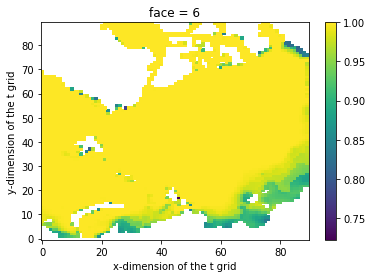

In [13]:
sum_of_corr[6].plot()

In [14]:
sum_of_corr[6,9,71].values

array(0.89102894)

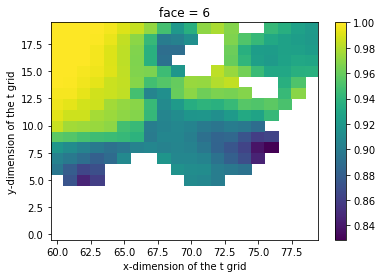

In [15]:
sum_of_corr[6,:20,60:80].plot()

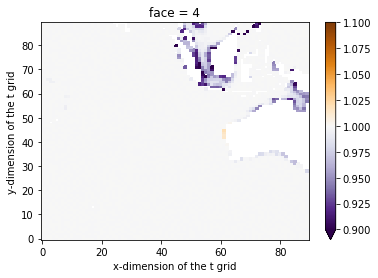

In [19]:
sum_of_corr[f].plot(vmin=0.9,vmax=1.1,cmap='PuOr_r')

In [20]:
import pyresample as pr

In [21]:
# Extract LLC coordinates
lons_1d = coords_main.XC.values.reshape(np.product(coords_main.XC.values.shape))
lats_1d = coords_main.YC.values.reshape(np.product(coords_main.YC.values.shape)) 

# Define original grid
orig_grid = pr.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)

# Spatial resolution
# Note: 1/4 degree is the default resolution in lon and lat to interpolate
dx = 0.25
dy = 0.25

# Longitudes latitudes to which we will we interpolate
lon_tmp = np.linspace(-180, 180, 360/dx)
lat_tmp = np.linspace(-89.5, 89.5, 90/dy)

# Define the lat lon points of the two parts.
new_grid_lon, new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
new_grid  = pr.geometry.GridDefinition(lons=new_grid_lon, lats=new_grid_lat)

field = pr.kd_tree.resample_nearest(orig_grid, sum_of_corr.values, new_grid, 
                                    radius_of_influence=100000, fill_value=None)

/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app
/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/pyresample/kd_tree.py:563: RuntimeWarning: invalid value encountered in sqrt
  distance_upper_bound=radius_of_influence)


/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/matplotlib/colors.py:956: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


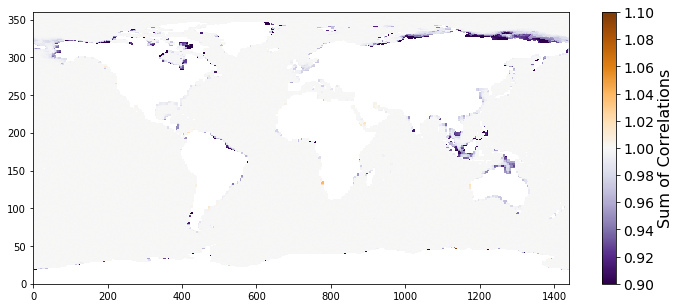

In [24]:
fig = plt.figure(figsize=(12,5))
p=plt.pcolormesh(field,vmin=0.9,vmax=1.1,cmap='PuOr_r')
cb = fig.colorbar(p,ticks=np.arange(-0.9,1.12,0.02))
cb.ax.tick_params(labelsize=14)
cb.set_label(r'Sum of Correlations',fontsize=16)

In [33]:
sum_of_terms = ds.hadv_Uanom_Tclim+ds.vadv_Uanom_Tclim+ds.hadv_Uclim_Tanom+ds.vadv_Uclim_Tanom+\
                ds.hdif+ds.vdif+ds.frc+ds.hadv_Uanom_Tanom+ds.vadv_Uanom_Tanom+ds.res

In [34]:
diff = (sum_of_terms-ds.tnd).sum(dim='time')

In [35]:
# Make copy of hFacC
mskC = coords_main.hFacC.copy(deep=True).load()

# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1

# Make 2D land mask for surface (This is just for plotting/mapping purposes)
land_mask = mskC[0]
land_mask.values[land_mask.values==0] = np.nan

In [9]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw, figsize=(10,4))
    for face, (j, i) in face_to_axis.items():
        data_ax = data.sel(face=face)
        ax = axes[j,i]
        yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            yincrease = False
        p = data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        #p = data_ax.plot(ax=ax, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')
    # use implicit way
    cbar = fig.colorbar(p, ax=axes.ravel().tolist(), shrink=0.95)

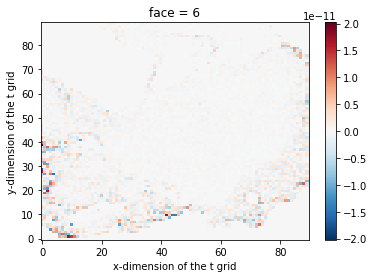

In [36]:
diff[6].plot(cmap='RdBu_r')

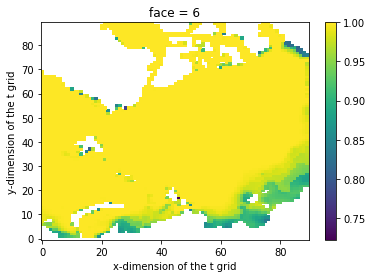

In [37]:
sum_of_corr[6].plot()

In [18]:
diff[8,55,16].values

array(1.81021565e-10)

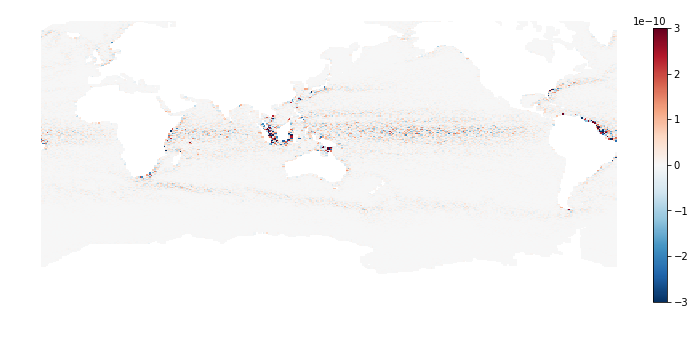

In [30]:
quick_llc_plot(diff*land_mask, add_colorbar=False, axis_off=True, cmap='RdBu_r',vmin=-3e-10,vmax=3e-10)

In [31]:
field = pr.kd_tree.resample_nearest(orig_grid, (diff*land_mask).values, new_grid, 
                                    radius_of_influence=100000, fill_value=None)

/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/pyresample/kd_tree.py:563: RuntimeWarning: invalid value encountered in sqrt
  distance_upper_bound=radius_of_influence)


/rigel/home/jt2796/miniconda/envs/default/lib/python3.6/site-packages/matplotlib/colors.py:956: RuntimeWarning: overflow encountered in true_divide
  resdat /= (vmax - vmin)


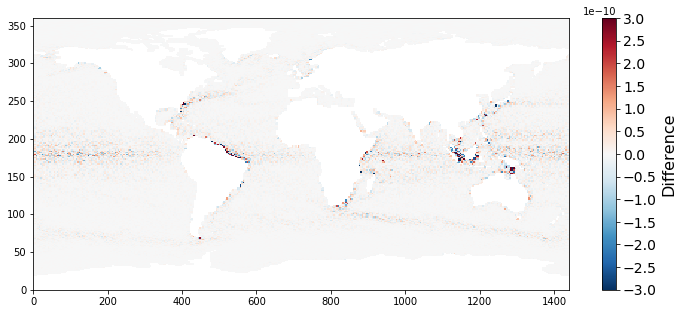

In [37]:
fig = plt.figure(figsize=(12,5))
p=plt.pcolormesh(field, cmap='RdBu_r', vmin=-3e-10, vmax=3e-10)
cb = fig.colorbar(p,ticks=np.arange(-3e-10,3.5e-10,0.5e-10))
cb.ax.tick_params(labelsize=14)
cb.set_label(r'Difference',fontsize=16)

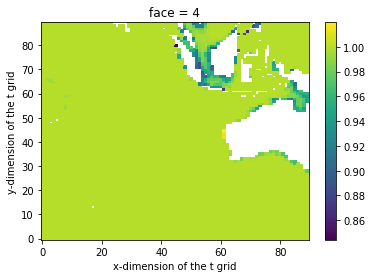

In [23]:
sum_of_corr[f].plot()#vmin=0.9,vmax=1.1,cmap='PuOr_r')

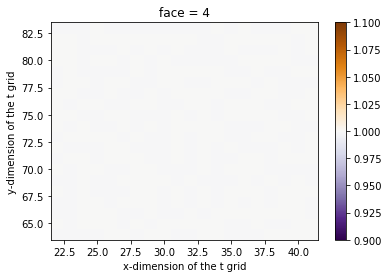

In [25]:
sum_of_corr[f,j-10:j+10,i-10:i+10].plot(vmin=0.9,vmax=1.1,cmap='PuOr_r')

In [40]:
sum_of_corr[f,j,i].values

array(0.88598811)

### Integrate over time

In [38]:
ds_int = (ds.isel(time=slice(1, -1))*coords_budg.isel(time=slice(1, -1)).dt).cumsum(dim='time')
ds_int['time'] = coords_main.time.isel(time=slice(1, -1))

In [39]:
results = dask.compute(ds_int.tnd[:,f,j,i],
                       ds_int.hadv_Uanom_Tclim[:,f,j,i],
                       ds_int.vadv_Uanom_Tclim[:,f,j,i],
                       ds_int.hadv_Uclim_Tanom[:,f,j,i], 
                       ds_int.vadv_Uclim_Tanom[:,f,j,i],
                       ds_int.hdif[:,f,j,i]+ds_int.vdif[:,f,j,i],
                       ds_int.frc[:,f,j,i],
                       ds_int.hadv_Uanom_Tanom[:,f,j,i]+ds_int.vadv_Uanom_Tanom[:,f,j,i],
                       ds_int.res[:,f,j,i])

In [40]:
total = results[1] + results[2] + results[3] + results[4] + results[5] + results[6] + results[7] + results[8]
adv = results[1] + results[2] + results[3] + results[4] + results[7]

In [41]:
df = pd.DataFrame({'tnd':results[0],
                   'hadv_Uanom_Tclim':results[1],'vadv_Uanom_Tclim':results[2],
                   'hadv_Uclim_Tanom':results[3],'vadv_Uclim_Tanom':results[4],
                   'dif':results[5],'frc':results[6],
                   'adv_Uanom_Tanom':results[7],'res':results[8],
                   'total':total,'adv':adv})

In [42]:
corr = pd.Series({term: df['tnd'].cov(df[term]) for term in df if term != 'tnd'})/np.var(df.tnd,ddof=1)

In [43]:
corr

hadv_Uanom_Tclim    7.502324e-02
vadv_Uanom_Tclim   -3.952658e-09
hadv_Uclim_Tanom   -1.330075e-02
vadv_Uclim_Tanom   -5.783327e-12
dif                -2.776536e-01
frc                 1.087756e+00
adv_Uanom_Tanom     2.858065e-02
res                -9.296630e-02
total               8.074391e-01
adv                 9.030313e-02
dtype: float64

In [44]:
corr[:8].sum()

0.8074391286645983

In [ ]:
fig, axes = plt.subplots(2, 1,figsize=(17,15))
fig.tight_layout()

plt.subplot(3, 1, 1)
plt.title(r'f = %s, j = %s, i = %s (%.2f $^{\circ}$W, %.2f $^{\circ}$N), where D = %s m' % (f,j,i,-lon,lat,d), 
          fontsize=16)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(adv.time, adv, lw=2, color='red', marker='.',label=varstrngs[10] + ' (%.2f)' % corr[9])
plt.plot(results[5].time, results[5], lw=2, color='orange', marker='.',label=varstrngs[11] + ' (%.2f)' % corr[4])
plt.plot(results[6].time, results[6], lw=2, color='blue', marker='.',label=varstrngs[12] + ' (%.2f)' % corr[5])
plt.plot(results[8].time, results[8], lw=2, color='green', marker='.',label=varstrngs[8] + ' (%.2f)' % corr[7])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
#plt.ylim([-2.5,1.8])
#plt.yticks(np.arange(-2.5,2.0,0.5),fontsize=14)
plt.ylabel(r'Integrated anomalies ($^{\circ}$C)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(3, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(results[1].time, results[1], lw=2, color='olive',marker='.',label=varstrngs[1] + ' (%.2f)' % corr[0])
plt.plot(results[2].time, results[2], lw=2, color='purple', marker='.',label=varstrngs[2] + ' (%.2f)' % corr[1])
plt.plot(results[3].time, results[3], lw=2, color='royalblue', marker='.',label=varstrngs[3] + ' (%.2f)' % corr[2])
plt.plot(results[4].time, results[4], lw=2, color='magenta', marker='.',label=varstrngs[4] + ' (%.2f)' % corr[3])
plt.plot(results[7].time, results[7], lw=2, color='gold', marker='.',label=varstrngs[7] + ' (%.2f)' % corr[6])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
#plt.ylim([-6,3.5])
#plt.yticks(np.arange(-6,3.5,0.5),fontsize=14)
plt.ylabel(r'Integrated anomalies ($^{\circ}$C)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(3, 1, 3)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time[1:-1], results[0][1:-1], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(total.time[1:-1], total[1:-1], lw=1, color='lavender', marker='.',label='Sum of terms')
plt.plot(results[0].time[1:-1], total[1:-1]-results[0][1:-1], lw=2, 
         color='darkslateblue', marker='.',label='Difference')
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
#plt.ylim([-0.8,1.1])
#plt.yticks(np.arange(-1.0,1.5,0.5),fontsize=14)
plt.ylabel(r'Integrated anomalies ($^{\circ}$C)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)

#plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()

### Detrend

In [39]:
def detrend(y):
    x = np.arange(0,len(y))
    not_nan_ind = ~np.isnan(y)
    if len(x[not_nan_ind]) < 2:
        return np.nan * y
    m, b, r_val, p_val, std_err = stats.linregress(x[not_nan_ind],y[not_nan_ind])
    return  y - (m*x + b)

In [40]:
ds_dtr = xr.Dataset(data_vars={})
for varname in ds_int.data_vars:
    ds_dtr[varname] = xr.DataArray(np.apply_along_axis(detrend, 0, ds_int[varname].transpose('time','face','j','i')),
                                   coords=[ds_int.time,ds_int.face,ds_int.j,ds_int.i],dims=['time','face','j','i'])

In [41]:
results = dask.compute(ds_dtr.tnd[:,f,j,i],
                       ds_dtr.hadv_Uanom_Tclim[:,f,j,i],
                       ds_dtr.vadv_Uanom_Tclim[:,f,j,i],
                       ds_dtr.hadv_Uclim_Tanom[:,f,j,i], 
                       ds_dtr.vadv_Uclim_Tanom[:,f,j,i],
                       ds_dtr.hdif[:,f,j,i]+ds_dtr.vdif[:,f,j,i],
                       ds_dtr.frc[:,f,j,i],
                       ds_dtr.hadv_Uanom_Tanom[:,f,j,i]+ds_dtr.vadv_Uanom_Tanom[:,f,j,i],
                       ds_dtr.res[:,f,j,i])

In [42]:
total = results[1] + results[2] + results[3] + results[4] + results[5] + results[6] + results[7] + results[8]
adv = results[1] + results[2] + results[3] + results[4] + results[7]

In [43]:
df = pd.DataFrame({'tnd':results[0],
                   'hadv_Uanom_Tclim':results[1],'vadv_Uanom_Tclim':results[2],
                   'hadv_Uclim_Tanom':results[3],'vadv_Uclim_Tanom':results[4],
                   'dif':results[5],'frc':results[6],
                   'adv_Uanom_Tanom':results[7],'res':results[8],
                   'total':total,'adv':adv})

In [44]:
corr = pd.Series({term: df['tnd'].cov(df[term]) for term in df if term != 'tnd'})/np.var(df.tnd,ddof=1)

In [45]:
corr

hadv_Uanom_Tclim    0.642405
vadv_Uanom_Tclim   -0.212389
hadv_Uclim_Tanom    1.120369
vadv_Uclim_Tanom    0.000425
dif                -0.097462
frc                 0.132859
adv_Uanom_Tanom    -0.213632
res                -0.373112
total               0.999462
adv                 1.337178
dtype: float64

In [46]:
corr[:8].sum()

0.9994624481962499

In [48]:
corr.iloc[[0,1,2,3,6]].sum()

1.3371777699139626

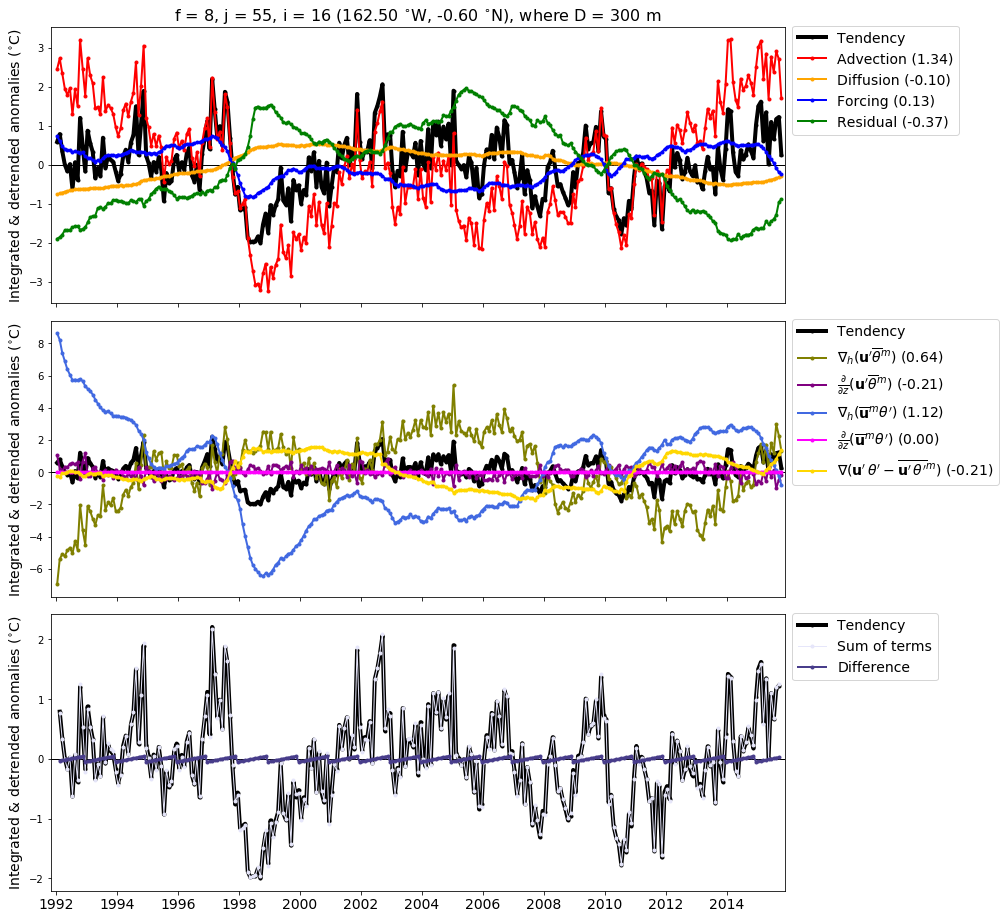

In [49]:
fig, axes = plt.subplots(2, 1,figsize=(17,15))
fig.tight_layout()

plt.subplot(3, 1, 1)
plt.title(r'f = %s, j = %s, i = %s (%.2f $^{\circ}$W, %.2f $^{\circ}$N), where D = %s m' % (f,j,i,-lon,lat,d), 
          fontsize=16)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(adv.time, adv, lw=2, color='red', marker='.',label=varstrngs[10] + ' (%.2f)' % corr[9])
plt.plot(results[5].time, results[5], lw=2, color='orange', marker='.',label=varstrngs[11] + ' (%.2f)' % corr[4])
plt.plot(results[6].time, results[6], lw=2, color='blue', marker='.',label=varstrngs[12] + ' (%.2f)' % corr[5])
plt.plot(results[8].time, results[8], lw=2, color='green', marker='.',label=varstrngs[8] + ' (%.2f)' % corr[7])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
#plt.ylim([-1.4,2.2])
#plt.yticks(np.arange(-1.0,2.5,0.5),fontsize=14)
plt.ylabel(r'Integrated & detrended anomalies ($^{\circ}$C)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(3, 1, 2)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time, results[0], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(results[1].time, results[1], lw=2, color='olive',marker='.',label=varstrngs[1] + ' (%.2f)' % corr[0])
plt.plot(results[2].time, results[2], lw=2, color='purple', marker='.',label=varstrngs[2] + ' (%.2f)' % corr[1])
plt.plot(results[3].time, results[3], lw=2, color='royalblue', marker='.',label=varstrngs[3] + ' (%.2f)' % corr[2])
plt.plot(results[4].time, results[4], lw=2, color='magenta', marker='.',label=varstrngs[4] + ' (%.2f)' % corr[3])
plt.plot(results[7].time, results[7], lw=2, color='gold', marker='.',label=varstrngs[7] + ' (%.2f)' % corr[6])
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'))
plt.setp(plt.gca(), 'xticklabels',[])
#plt.ylim([-3,4.5])
#plt.yticks(np.arange(-3.0,5.0,0.5),fontsize=14)
plt.ylabel(r'Integrated & detrended anomalies ($^{\circ}$C)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

plt.subplot(3, 1, 3)
plt.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
plt.plot(results[0].time[1:-1], results[0][1:-1], lw=4, color='black', marker='.',label=varstrngs[0])
plt.plot(total.time[1:-1], total[1:-1], lw=1, color='lavender', marker='.',label='Sum of terms')
plt.plot(results[0].time[1:-1], total[1:-1]-results[0][1:-1], lw=2, 
         color='darkslateblue', marker='.',label='Difference')
plt.xlim([ds.time.values[0],ds.time.values[-1]])
plt.xlim(['1991-12-01','2016-01-01'])
plt.xticks(pd.date_range('1992-01-15','2016-01-15',freq='24M'),fontsize=14)
#plt.ylim([-1.2,1.2])
#plt.yticks(np.arange(-1.0,1.5,0.5),fontsize=14)
plt.ylabel(r'Integrated & detrended anomalies ($^{\circ}$C)',fontsize=14)
plt.legend(fontsize=14,loc='upper left',bbox_to_anchor=(1.0, 1.03))

fig.subplots_adjust(left=0.1, right=0.7, bottom=0.1, top=0.9)

#plt.savefig('/rigel/home/jt2796/figure.png')
plt.show()